# **---= Permite salvar os erros que ocorreram com a função Evaluate =---**

In [ ]:
!pip install ultralytics #opencv-python pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml
import numpy as np
import cv2
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import timm
from sklearn.metrics import accuracy_score, f1_score
from itertools import product
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from ultralytics import YOLO
import torch.nn as nn
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sympy

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
path = os.getcwd()
print(path)

#os.chdir(path)
#file_log = open(path + "/mensagem_final_classificar_V2.txt", "a")

/content


In [ ]:
# === Configurações Gerais ===
NUM_CLASSES = 15
INPUT_SIZE = 224  # conforme modelo Small treinado em 224×224
BATCH_SIZE = 32 # Padrão: 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_LEAF = "/content/drive/MyDrive/TCC/Datasets/Imagens Folhas/Especies" # Dataset de folhas usado
DATASET_BARK = "/content/drive/MyDrive/TCC/Datasets/Imagens tronco/EspeciesCascas" # Dataset de cascas usado

In [ ]:
#  ===Dataset customizado ===
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Assumindo estrutura: root_dir/class_x/imagename.jpg
        self.samples = []
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name:i for i,cls_name in enumerate(classes)}
        for cls_name in classes:
            cls_path = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_path):
                continue
            for fname in os.listdir(cls_path):
                if fname.lower().endswith(('.png','.jpg','.jpeg','bmp')):
                    self.samples.append((os.path.join(cls_path, fname), self.class_to_idx[cls_name]))
        # embaralhar?
        np.random.seed(42)
        np.random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        # leitura via OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # redimensionar
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        # converter para float32 e normalizar [0,1]
        img = img.astype(np.float32) / 255.0
        # talvez normalização adicional conforme modelo (media/std)
        # usando valores padrão ImageNet
        mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
        img = (img - mean) / std
        # mudar de H×W×C para C×H×W
        img = np.transpose(img, (2,0,1))
        img_tensor = torch.from_numpy(img)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_tensor, label_tensor

In [ ]:
def stratified_split(dataset, test_split=0.1, valid_split=0.2, seed=42):
    """
    Divide o dataset em treino, validação e teste mantendo a proporção das classes.

    Args:
        dataset: Dataset com atributo 'samples' [(path, label), ...]
        test_split: Proporção do teste em relação ao total (padrão: 0.1 = 10%)
        valid_split: Proporção da validação em relação ao (treino+validação) (padrão: 0.2 = 20%)
        seed: Seed para reprodutibilidade

    Returns:
        train_ds, valid_ds, test_ds: Subsets estratificados

    Nota: Com os valores padrão, a divisão real é:
        - Treino: 72% do total
        - Validação: 18% do total
        - Teste: 10% do total
    """
    # Extrair os rótulos
    labels = [label for _, label in dataset.samples]

    # Primeiro, separar Teste
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_split, random_state=seed)
    train_valid_idx, test_idx = next(sss1.split(np.zeros(len(labels)), labels))

    # Agora, separar Validação dentro do conjunto de treino+validação
    labels_train_valid = np.array(labels)[train_valid_idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=valid_split, random_state=seed)
    train_idx, valid_idx = next(sss2.split(np.zeros(len(labels_train_valid)), labels_train_valid))

    # Reindexar para o dataset original
    train_idx = np.array(train_valid_idx)[train_idx]
    valid_idx = np.array(train_valid_idx)[valid_idx]

    # Criar Subsets
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    valid_ds = torch.utils.data.Subset(dataset, valid_idx)
    test_ds  = torch.utils.data.Subset(dataset, test_idx)

    return train_ds, valid_ds, test_ds

In [ ]:
# === Função para treinar por uma época ===
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(loader, desc="Train"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# === Função para avaliar e salvar imagens classificadas incorretamente ===
def evaluate_and_save_errors(model, loader, class_names=None, save_errors=True,
                              output_dir="classification_errors", model_name="model"):
    """
    Avalia o modelo e opcionalmente salva as imagens classificadas incorretamente.

    Args:
        model: Modelo PyTorch a ser avaliado
        loader: DataLoader com o dataset de teste
        class_names: Lista com os nomes das classes
        save_errors: Se True, salva as imagens com erro de classificação
        output_dir: Diretório base onde salvar os erros
        model_name: Nome do modelo (usado para criar subpastas)

    Returns:
        acc: Acurácia
        f1: F1-Score
        error_info: Lista de dicionários com informações sobre os erros
    """
    model.eval()
    all_preds = []
    all_labels = []
    error_info = []

    # Criar diretório para salvar erros se necessário
    if save_errors:
        model_error_dir = os.path.join(output_dir, model_name)
        os.makedirs(model_error_dir, exist_ok=True)

        # Criar CSV para log dos erros
        csv_path = os.path.join(model_error_dir, "classification_errors.csv")
        csv_file = open(csv_path, 'w', encoding='utf-8')
        csv_file.write("imagem,classe_verdadeira,classe_predita,confianca,indice\n")

    sample_idx = 0
    with torch.no_grad():
        for batch_imgs, batch_labels in tqdm(loader, desc="Eval"):
            batch_imgs = batch_imgs.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            outputs = model(batch_imgs)

            # Obter probabilidades e predições
            probs = torch.nn.functional.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)

            # Processar cada imagem do batch
            for i in range(batch_imgs.size(0)):
                pred = preds[i].item()
                label = batch_labels[i].item()
                confidence = confidences[i].item()

                all_preds.append(pred)
                all_labels.append(label)

                # Se houve erro de classificação
                if pred != label and save_errors:
                    # Obter o caminho original da imagem
                    dataset = loader.dataset
                    if hasattr(dataset, 'dataset'):  # Se for um Subset
                        base_dataset = dataset.dataset
                        actual_idx = dataset.indices[sample_idx]
                    else:
                        base_dataset = dataset
                        actual_idx = sample_idx

                    img_path, _ = base_dataset.samples[actual_idx]
                    img_name = os.path.basename(img_path)

                    # Nome da classe verdadeira e predita
                    true_class = class_names[label] if class_names else f"class_{label}"
                    pred_class = class_names[pred] if class_names else f"class_{pred}"

                    # Criar subpasta para cada tipo de erro
                    error_subdir = os.path.join(model_error_dir, f"{true_class}_as_{pred_class}")
                    os.makedirs(error_subdir, exist_ok=True)

                    # Copiar imagem original
                    dest_path = os.path.join(error_subdir, img_name)
                    shutil.copy2(img_path, dest_path)

                    # Salvar informação do erro
                    error_dict = {
                        'image_path': img_path,
                        'saved_path': dest_path,
                        'true_label': label,
                        'true_class': true_class,
                        'pred_label': pred,
                        'pred_class': pred_class,
                        'confidence': confidence,
                        'index': actual_idx
                    }
                    error_info.append(error_dict)

                    # Escrever no CSV
                    csv_file.write(f"{img_name},{true_class},{pred_class},{confidence:.4f},{actual_idx}\n")

                sample_idx += 1

    if save_errors:
        csv_file.close()
        print(f"\n✅ Erros salvos em: {model_error_dir}")
        print(f"📊 Total de erros: {len(error_info)}/{sample_idx}")

    # Calcular métricas
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(12, 10))
    sn.set(font_scale=1.2)
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues',
               annot_kws={"size": 12}, cbar_kws={'label': 'Contagem'})
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.title(f'Matriz de Confusão - {model_name}\nAcurácia: {acc:.4f} | F1-Score: {f1:.4f}')
    plt.tight_layout()

    # Salvar matriz de confusão
    if save_errors:
        cm_path = os.path.join(model_error_dir, "confusion_matrix.png")
        plt.savefig(cm_path, dpi=150, bbox_inches='tight')
        print(f"📈 Matriz de confusão salva em: {cm_path}")

    plt.show()

    return acc, f1, error_info

In [ ]:
# ======= Função para montar o modelo MobileNetV4 adaptado para 15 classes ========
def create_mobilenet(num_classes=NUM_CLASSES, pretrained=True):
    model = timm.create_model('mobilenetv4_conv_small.e1200_r224_in1k', pretrained=pretrained)

    # Descongela tudo
    for param in model.parameters():
        param.requires_grad = True

    # Congela apenas o final
    for name, param in model.named_parameters():
        # Congela os primeiros blocos/stages da MobileNet
        # Congela 3 stages = 60% (mais conservador)
        if any(layer in name for layer in ['conv_stem', 'stages.0', 'stages.1', 'stages.2']):
            param.requires_grad = False

    model.reset_classifier(num_classes=num_classes)
    return model.to(DEVICE)

# ======= Função para montar o modelo ViT-Tiny adaptado para 15 classes ========
def create_vit(num_classes=NUM_CLASSES, pretrained=True):
    # Carregar modelo base
    model = timm.create_model('vit_tiny_patch16_224', pretrained=pretrained)

    # Primeiro, descongela tudo
    for param in model.parameters():
        param.requires_grad = True

    # Agora CONGELA apenas os blocos iniciais (features básicas)
    for name, param in model.named_parameters():
        # Congela APENAS 2 blocos iniciais (17%), NÃO congela patch_embed
        if any(x in name for x in ["blocks.0", "blocks.1"]):
            param.requires_grad = False

    model.reset_classifier(num_classes=num_classes)
    return model.to(DEVICE)

# ======= Função para montar o modelo YOLOv12 adaptado para 15 classes ========
def create_yolo(num_classes=NUM_CLASSES, pretrained=True, freeze_stages=3):
    """
    Cria modelo de classificação usando backbone do YOLOv12.

    Args:
        num_classes: Número de classes para classificação
        pretrained: Se True, carrega pesos pré-treinados
        freeze_stages: Número de stages iniciais para congelar (0-4)
                      2 = recomendado (mantém features básicas: bordas, cores, texturas) OBS: Também é recomendado 3

    Estrutura YOLOv12:
        Stage 0: Stem - features muito básicas (bordas)
        Stage 1: C3k2 blocks - cores e texturas simples
        Stage 2: C3k2 blocks - texturas complexas
        Stage 3: C3k2 blocks - padrões intermediários
        Stage 4: C3k2 + SPPF - features de alto nível
    """

    # Carregar YOLOv12 pré-treinado
    if pretrained:
        yolo = YOLO('yolo12n.pt')  # ou yolo12s.pt, yolo12m.pt, yolo12l.pt, yolo12x.pt
    else:
        yolo = YOLO('yolo12n.yaml')  # modelo sem pesos

    # Acessar o modelo PyTorch interno
    full_model = yolo.model

    # Extrair apenas o backbone (sem neck e head de detecção)
    # YOLOv12 geralmente tem ~10 layers no backbone
    backbone_layers = []
    for i in range(10):  # Ajuste se necessário
        if i < len(full_model.model):
            backbone_layers.append(full_model.model[i])
        else:
            break

    backbone = nn.Sequential(*backbone_layers)

    # === CONGELAMENTO CORRETO ===
    # Primeiro, descongela tudo
    for param in backbone.parameters():
        param.requires_grad = True

    # Mapear layers para stages (aproximado para YOLOv12n)
    # Isso pode variar ligeiramente dependendo da versão (n/s/m/l/x)
    stage_to_layers = {
        0: [0, 1],      # Stem: Conv inicial
        1: [2, 3],      # Stage 1: Primeiros C3k2 blocks
        2: [4, 5],      # Stage 2: C3k2 intermediários
        3: [6, 7],      # Stage 3: C3k2 avançados
        4: [8, 9],      # Stage 4: C3k2 finais + SPPF
    }

    # Congela apenas os stages iniciais (features básicas)
    frozen_layers = []
    for stage_idx in range(freeze_stages):
        if stage_idx in stage_to_layers:
            for layer_idx in stage_to_layers[stage_idx]:
                if layer_idx < len(backbone):
                    for param in backbone[layer_idx].parameters():
                        param.requires_grad = False
                    frozen_layers.append(layer_idx)

    #print(f"❄️  Layers congeladas (features básicas): {frozen_layers}")

    # === AUTO-DETECTAR DIMENSÕES ===
    backbone.eval()
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224)
        if torch.cuda.is_available():
            dummy_input = dummy_input.cuda()
            backbone = backbone.cuda()

        features = backbone(dummy_input)

        # YOLOv12 pode retornar múltiplas escalas, pegar a última
        if isinstance(features, (list, tuple)):
            features = features[-1]

        # Shape: [batch, channels, height, width]
        in_features = features.shape[1]
        #print(f"✅ Features do backbone: {in_features} channels")
        #print(f"📐 Shape de saída: {features.shape}")

    backbone.train()

    # === CABEÇA DE CLASSIFICAÇÃO ===
    classifier_head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),           # Global Average Pooling
        nn.Flatten(),
        nn.BatchNorm1d(in_features),
        nn.Dropout(0.3),
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)
    )

    # Modelo completo
    full_classifier = nn.Sequential(backbone, classifier_head)

    # Resumo
    total_params = sum(p.numel() for p in full_classifier.parameters())
    trainable_params = sum(p.numel() for p in full_classifier.parameters() if p.requires_grad)
    #print(f"\n📊 Parâmetros totais: {total_params:,}")
    #print(f"🔥 Parâmetros treináveis: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
    #print(f"❄️  Parâmetros congelados: {total_params-trainable_params:,} ({(total_params-trainable_params)/total_params*100:.1f}%)")

    return full_classifier.to(DEVICE)

In [ ]:
# === Função principal para rodar Grid Search sobre epochs e learning rate ===
def run_test(dataset_root, lr_list, epoch_list,  whichModel, valid_split=0.2, test_split=0.1):
    # whichModel só pode ser "bark" ou "leaf"
    if whichModel not in ["bark", "leaf"]:
        raise ValueError("whichModel deve ser 'bark' ou 'leaf'")

    # carregar dataset completo
    global full_ds, train_ds, valid_ds, test_ds
    full_ds = ImageFolderDataset(dataset_root)
    total_len = len(full_ds)
    test_len  = int(total_len * test_split)
    valid_len = int((total_len - test_len) * valid_split)
    train_len = total_len - test_len - valid_len
    #train_ds, valid_ds, test_ds = random_split(full_ds, [train_len, valid_len, test_len], generator=torch.Generator().manual_seed(42))
    train_ds, valid_ds, test_ds = stratified_split(full_ds, test_split=test_split, valid_split=valid_split, seed=42)

    print(f"\nDataset: {total_len} imagens")

     # ✅ Extrair nomes ORIGINAIS das classes na ordem correta
    class_names = [name for name, idx in sorted(full_ds.class_to_idx.items(), key=lambda x: x[1])]
    print(f"Classes detectadas ({len(full_ds.class_to_idx.keys())}): {class_names}")
    print(f"Treino: {train_len} | Validação: {valid_len} | Teste: {test_len}")

    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    criterion = nn.CrossEntropyLoss()

    modelMN = create_mobilenet(num_classes=NUM_CLASSES, pretrained=False)
    modelMN.load_state_dict(torch.load(f"/content/drive/MyDrive/TCC/Datasets/weights/mobilenetv4_{whichModel}_best.pt", map_location=DEVICE))
    modelMN.to(DEVICE)
    acc_test, f1_test, errors = evaluate_and_save_errors(
        modelMN,
        test_loader,
        class_names,
        save_errors=True,
        output_dir="/content/drive/MyDrive/TCC/classification_errors",
        model_name=f"MobileNetV4_{whichModel}"
    )
    print(f"MobileNetV4 - acc: {acc_test:.6f}, f1: {f1_test:.6f}")

    modelV = create_vit(num_classes=NUM_CLASSES, pretrained=False)
    modelV.load_state_dict(torch.load(f"/content/drive/MyDrive/TCC/Datasets/weights/ViT_Tiny_{whichModel}_best.pt", map_location=DEVICE))
    modelV.to(DEVICE)
    acc_test, f1_test, errors = evaluate_and_save_errors(
        modelV,
        test_loader,
        class_names,
        save_errors=True,
        output_dir="/content/drive/MyDrive/TCC/classification_errors",
        model_name=f"ViT_Tiny_{whichModel}"
    )
    print(f"ViT Tiny - acc: {acc_test:.6f}, f1: {f1_test:.6f}")

    modelY = create_yolo(num_classes=NUM_CLASSES, pretrained=True)
    modelY.load_state_dict(torch.load(f"/content/drive/MyDrive/TCC/Datasets/weights/YOLOv12_{whichModel}_best.pt", map_location=DEVICE))
    modelY.to(DEVICE)
    acc_test, f1_test, errors = evaluate_and_save_errors(
        modelY,
        test_loader,
        class_names,
        save_errors=True,
        output_dir="/content/drive/MyDrive/TCC/classification_errors",
        model_name=f"YOLOv12_{whichModel}"
    )
    print(f"YOLOv12 - acc: {acc_test:.6f}, f1: {f1_test:.6f}")


--------------- Testes dos melhores modelos ---------------


--------------- Folhas ---------------
Início...




--------------- Cascas ---------------
Início...

Dataset: 467 imagens
Classes detectadas (15): ['Abacateiro', 'Araca', 'Brinco de Indio', 'Cajueiro', 'Carvalho', 'Caterete', 'Cerejeira', 'Coite', 'Fruta do conde', 'Grevilha', 'Jambolao', 'Laranja Champanhe', 'Louro Pardo', 'Pau Brasil', 'Peroba Rosa']
Treino: 262 | Validação: 65 | Teste: 140


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval: 100%|██████████| 5/5 [00:46<00:00,  9.31s/it]



✅ Erros salvos em: /content/drive/MyDrive/TCC/classification_errors/MobileNetV4_bark
📊 Total de erros: 3/141
📈 Matriz de confusão salva em: /content/drive/MyDrive/TCC/classification_errors/MobileNetV4_bark/confusion_matrix.png


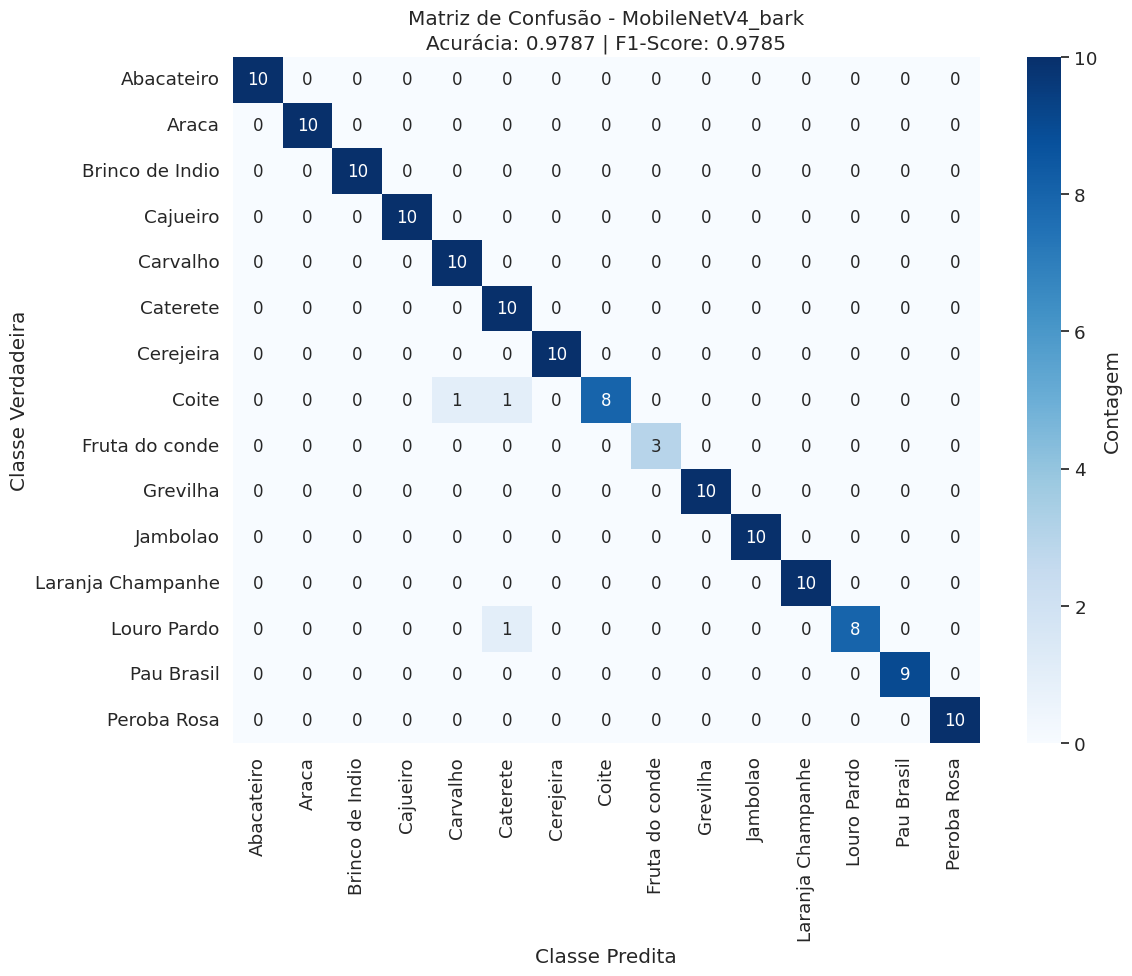

MobileNetV4 - acc: 0.978723, f1: 0.978540


Eval:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]



✅ Erros salvos em: /content/drive/MyDrive/TCC/classification_errors/ViT_Tiny_bark
📊 Total de erros: 2/141
📈 Matriz de confusão salva em: /content/drive/MyDrive/TCC/classification_errors/ViT_Tiny_bark/confusion_matrix.png


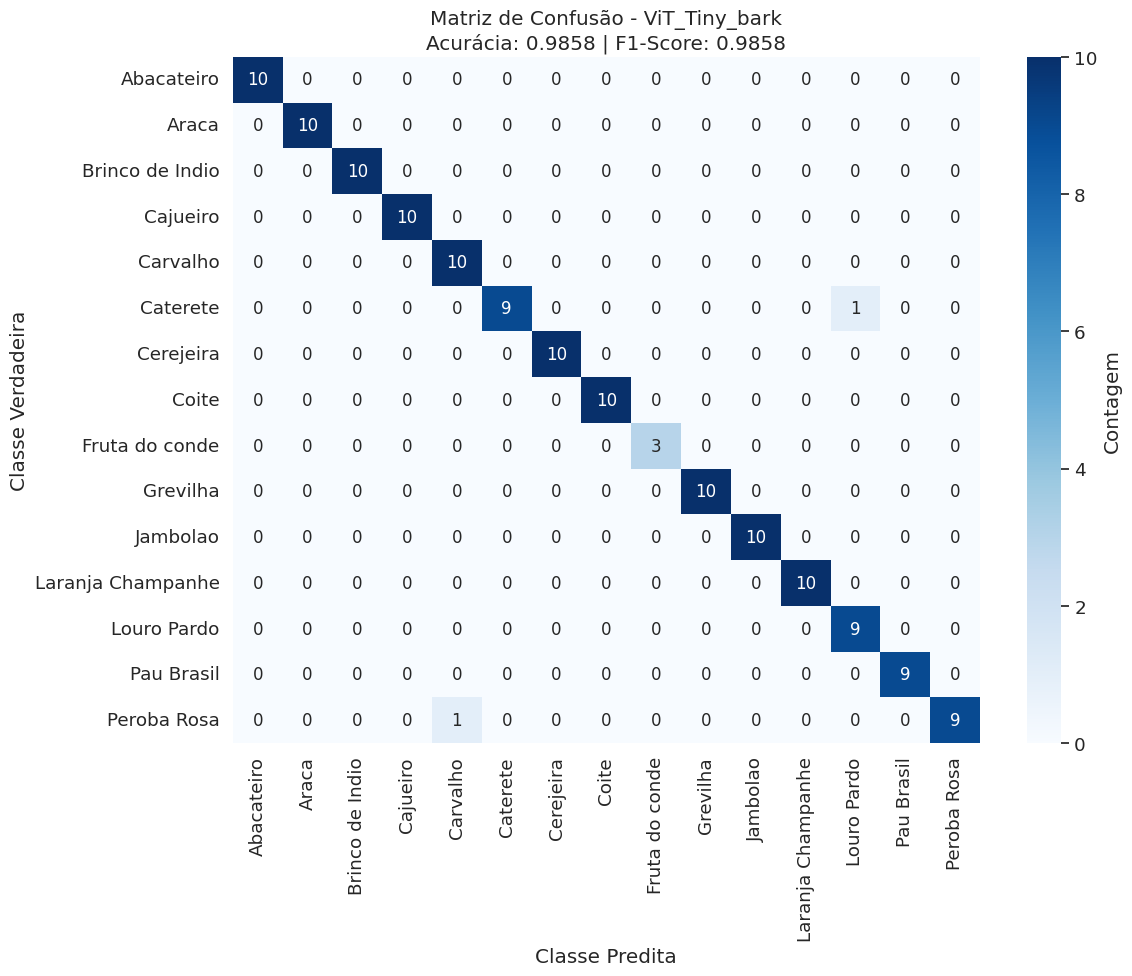

ViT Tiny - acc: 0.985816, f1: 0.985798


Eval:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Eval: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]



✅ Erros salvos em: /content/drive/MyDrive/TCC/classification_errors/YOLOv12_bark
📊 Total de erros: 2/141
📈 Matriz de confusão salva em: /content/drive/MyDrive/TCC/classification_errors/YOLOv12_bark/confusion_matrix.png


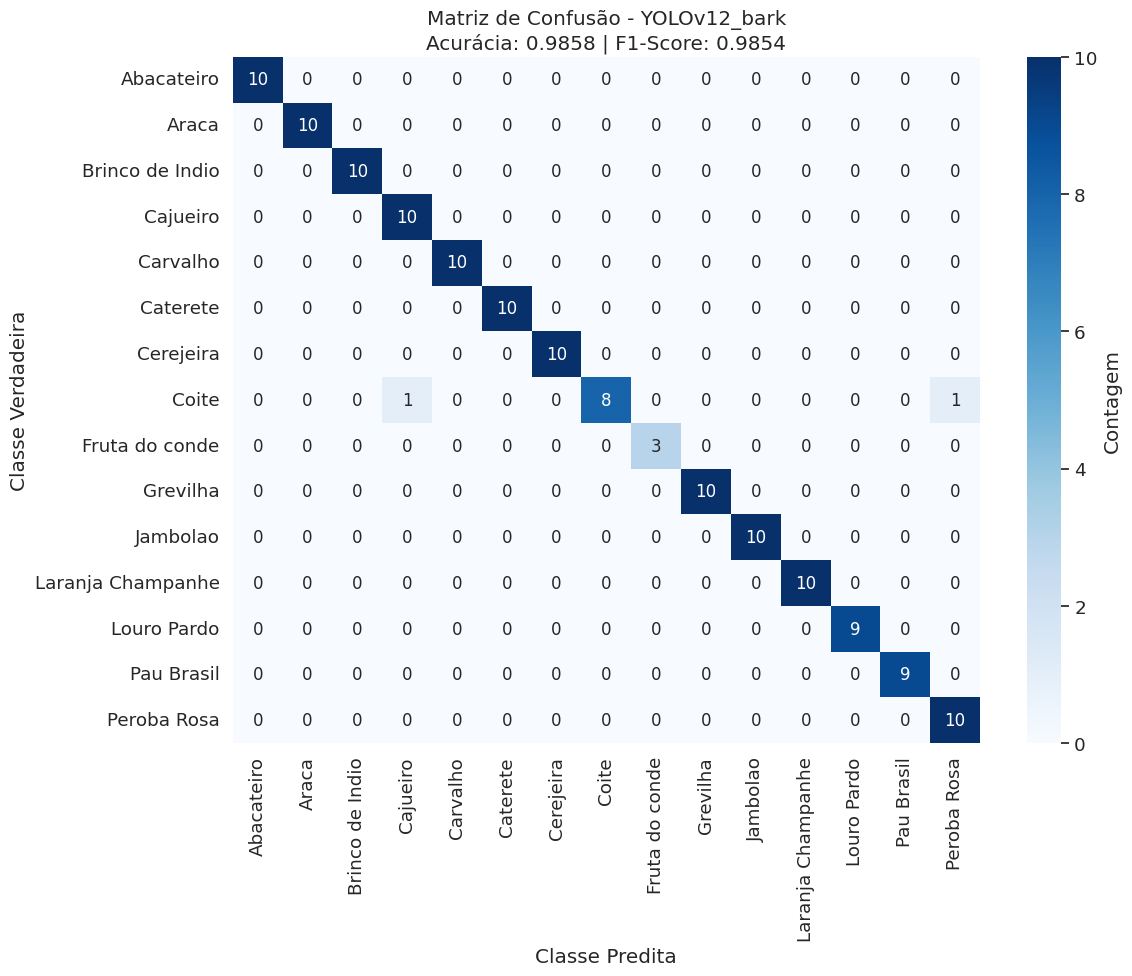

YOLOv12 - acc: 0.985816, f1: 0.985365
...Fim



In [ ]:
# === Função Main ===
if __name__ == "__main__":
    try:
        print("\n--------------- Testes dos melhores modelos ---------------\n")
        # Defina aqui o caminho para o diretório de imagens
        dataset_leaf = DATASET_LEAF
        dataset_bark = DATASET_BARK
        # Defina lista de valores para hyperparâmetros
        lr_list    = [5e-4, 1e-4, 5e-5, 1e-5]
        epoch_list = [10, 20, 30]
        # Rodar grid
        print("\n--------------- Folhas ---------------\nInício...")
        #run_test(dataset_leaf, lr_list, epoch_list, "leaf", valid_split=0.2, test_split=0.3)
        print("\n\n\n\n--------------- Cascas ---------------\nInício...")
        #run_test(dataset_bark, lr_list, epoch_list, "bark", valid_split=0.2, test_split=0.3)
        print("...Fim\n")
    except KeyboardInterrupt:
        print("Programa encerrado via terminal...")